<a href="https://colab.research.google.com/github/U-Revanth/ml1/blob/main/Dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
! pip install opendatasets

In [12]:
import opendatasets as od

In [13]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"revanth009","key":"31088349e5a5fe835ba1cd78f38a6a31"}'}

In [14]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [15]:
!kaggle competitions download -c dogs-vs-cats
!unzip dogs-vs-cats.zip



 99% 804M/812M [00:02<00:00, 247MB/s]
100% 812M/812M [00:02<00:00, 323MB/s]
Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 686s 1s/step - accuracy: 0.6199 - loss: 0.6762 - val_accuracy: 0.7538 - val_loss: 0.5181
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 683s 1s/step - accuracy: 0.7920 - loss: 0.4508 - val_accuracy: 0.7714 - val_loss: 0.4785
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 724s 1s/step - accuracy: 0.8487 - loss: 0.3400 - val_accuracy: 0.7780 - val_loss: 0.4860
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 695s 1s/step - accuracy: 0.9188 - loss: 0.2040 - val_accuracy: 0.7870 - val_loss: 0.5724
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 689s 1s/step - accuracy: 0.9681 - loss: 0.0956 - val_accuracy: 0.7724 - val_loss: 0.7695


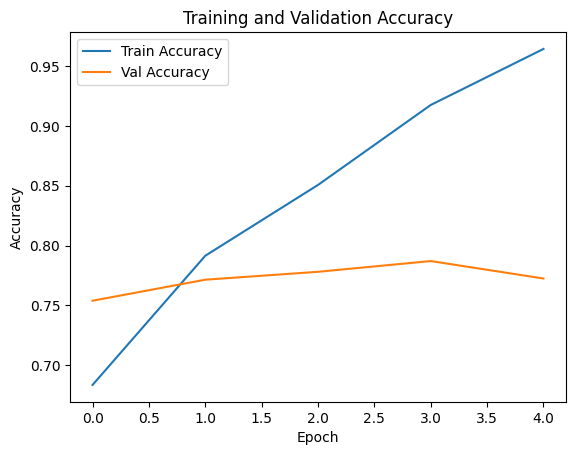

In [17]:
import os
import zipfile
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# STEP 1: Unzip the dataset
zip_path = "/content/train.zip"
extract_path = "train_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# STEP 2: Move cat and dog images to subfolders
base_dir = "data"
train_dir = os.path.join(base_dir, "train")
cat_dir = os.path.join(train_dir, "cats")
dog_dir = os.path.join(train_dir, "dogs")

os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Move images into respective folders
source_dir = os.path.join(extract_path, "train")
for fname in os.listdir(source_dir):
    if fname.startswith("cat"):
        shutil.move(os.path.join(source_dir, fname), cat_dir)
    elif fname.startswith("dog"):
        shutil.move(os.path.join(source_dir, fname), dog_dir)

# STEP 3: Data preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# STEP 4: Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# STEP 5: Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

# STEP 6: Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# (Optional) STEP 7: Save model
model.save("dog_cat_classifier.h5")